# Анализ Olist

In [1]:
from typing import List
from psycopg2 import connect

import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

Напишем функцию для выполнения SQL запросов из задания

In [2]:
def execute_sql_from_file(path: str, conn: connect) -> List[pd.DataFrame]:
    results = []
    
    with open(path, "r", encoding='utf-8') as f:
        sql_content = f.read()
        
    queries = [q.strip() for q in sql_content.split(';') if q.strip()]
    with conn.cursor() as cur:
        for query in queries:
            cur.execute(query)
            
            col_names = [desc[0] for desc in cur.description]
            data = cur.fetchall()
            results.append(pd.DataFrame(data, columns=col_names))
            
    return results

Создадим подключение к БД

In [3]:
conn = connect(
    dbname="olist",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

## Пункт 1

Определите, на какие категории товаров в штате Бразилиа пользователи чаще всего оставляют комментарии и подумайте, почему они это делают.

In [4]:
task1_res = execute_sql_from_file("../scripts/03_task1.sql", conn)

task1_res

[   product_category_name  review_count
 0          health_beauty           245
 1         sports_leisure           224
 2         bed_bath_table           208
 3  computers_accessories           160
 4             housewares           154
 5        furniture_decor           149
 6          watches_gifts           146
 7                   auto           111
 8                   toys            96
 9              telephony            94]

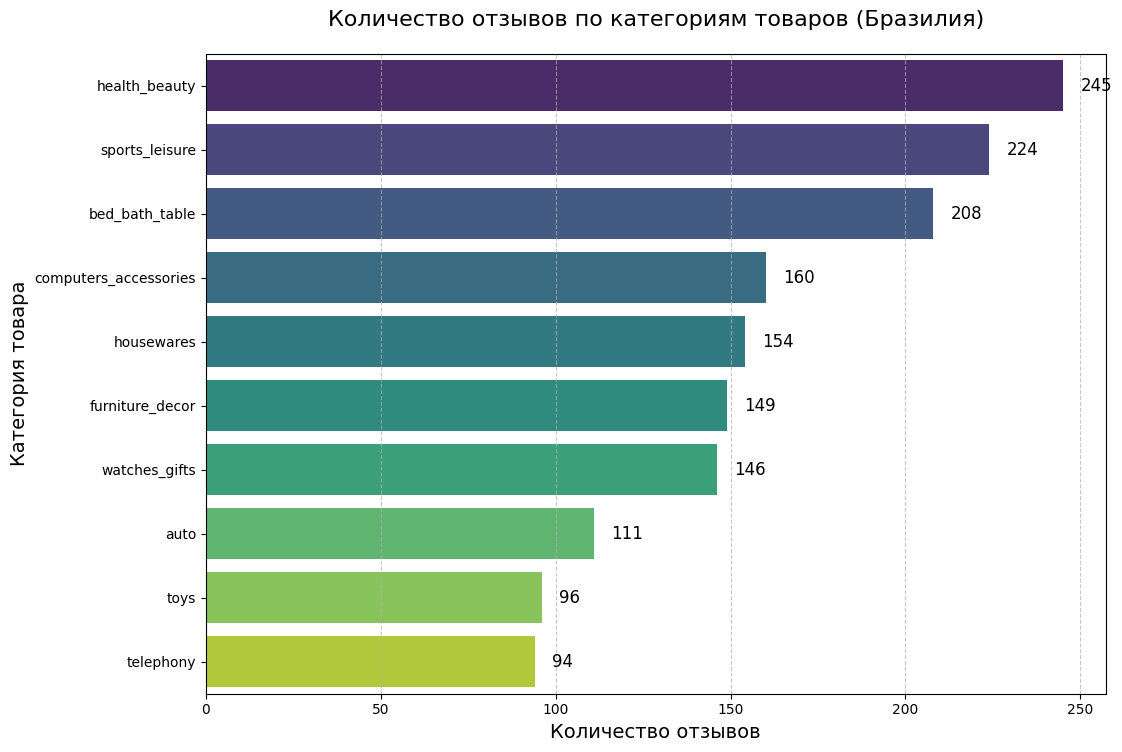

In [5]:
plt.figure(figsize=(12, 8))

sns.barplot(
    x=task1_res[0]["review_count"],
    y=task1_res[0]["product_category_name"],
    palette="viridis",
    hue=task1_res[0]["product_category_name"],
    legend=False
)

plt.title("Количество отзывов по категориям товаров (Бразилия)", pad=20, fontsize=16)
plt.xlabel("Количество отзывов", fontsize=14)
plt.ylabel("Категория товара", fontsize=14)

plt.grid(axis="x", linestyle="--", alpha=0.7)

for i, v in enumerate(task1_res[0]["review_count"]):
    plt.text(v + 5, i, str(v), color='black', va='center', fontsize=12)

plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

plt.show()

Видим, что чаще всего пользователи оставляют отзывы на такие категории как:
- Красота и здоровье
- Спортивная экипировка
- Постельное белье и домашний текстиль

Скорее всего на эти товары чаще всего оставляют отзывы по причине того, что их нужно тестировать на практике, невозможно понять эффект крема (из категории красота и здоровье), не использовав его на себе, так же невозможно оценить долговечность товаров из категорий спортивная экипировка и постельное белье, не пользуясь ими некоторое время.

## Пункт 2

In [6]:
task2_res = execute_sql_from_file("../scripts/04_task2.sql", conn)

task2_res

[         review_delay_hours
 0       21.7830555555555556
 1       27.0869444444444444
 2       38.6066666666666667
 3       22.0350000000000000
 4       34.4480555555555556
 ...                     ...
 98405  185.3083333333333333
 98406   68.1116666666666667
 98407   33.1786111111111111
 98408   36.9869444444444444
 98409   21.0302777777777778
 
 [98410 rows x 1 columns],
                           metric  total_reviews avg_hours percentile_25_hours  \
 0  Review Response Time Analysis          98410     75.60               24.11   
 
   percentile_75_hours min_hours max_hours  
 0               74.45      2.14  12448.78  ,
                           review_id review_comment_message  review_score  \
 0  40dad6438b6cbec46d936bec2377778c                   None             1   
 
   review_creation_date review_answer_timestamp  review_delay_hours  
 0           2017-03-24     2018-08-24 16:46:52  12448.781111111111  ]

Вторая таблица хранит в себе некоторые статистические данные о времени заполнения пользователями формы

In [7]:
task2_res[1]

,metric,total_reviews,avg_hours,percentile_25_hours,percentile_75_hours,min_hours,max_hours
0,Review Response Time Analysis,98410,75.60,24.11,74.45,2.14,12448.78


Интересным наблюдением является то, что максимальное время заполнения формы составляет 12448.78 часов, что примерно 518 дней. Скорее всего кого-то спустя полтора года активного пользования товара что-то не устроило. Посмотрим на оценку отзывы

In [8]:
task2_res[2]

,review_id,review_comment_message,review_score,review_creation_date,review_answer_timestamp,review_delay_hours
0,40dad6438b6cbec46d936bec2377778c,None,1,2017-03-24,2018-08-24 16:46:52,12448.781111111111


Действительно, оценка `1`, возможно купленный товар сломался и пользователях на эмоциях решил вспомнить о форме. При этом текста у отзыва нет

Посмотрим на рапределение времени ответа пользователей на форму

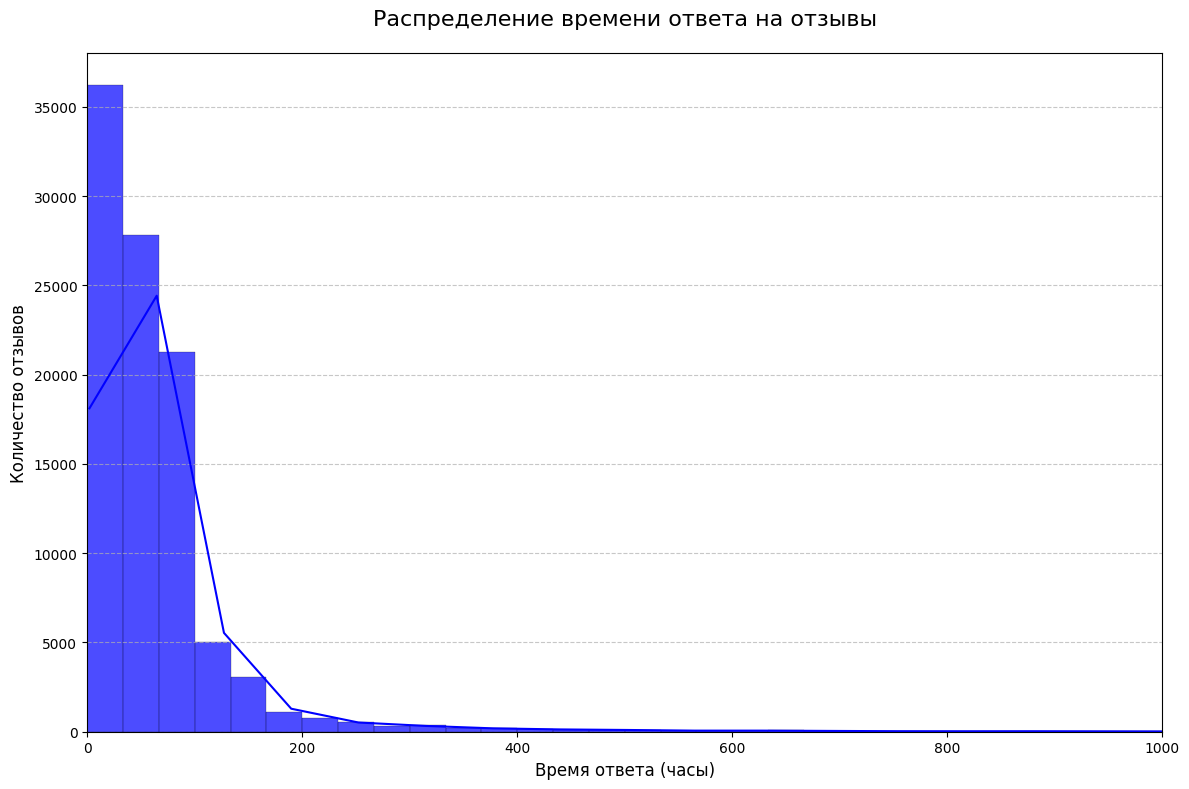

In [9]:
plt.figure(figsize=(12, 8))

sns.histplot(
    task2_res[0]['review_delay_hours'], 
    bins=30, 
    binrange=(0, 1000),
    kde=True, 
    color='blue', 
    alpha=0.7
)

plt.title("Распределение времени ответа на отзывы", fontsize=16, pad=20)
plt.xlabel("Время ответа (часы)", fontsize=12)
plt.ylabel("Количество отзывов", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

В основном пользователи отвечают на форму в первые 200 часов

## Пункт 3

In [10]:
task3_res = execute_sql_from_file("../scripts/05_task3.sql", conn)

task3_res

[   state avg_order_value
 0     PB          248.33
 1     AC          234.29
 2     RO          233.20
 3     AP          232.33
 4     AL          227.08
 5     RR          218.80
 6     PA          215.92
 7     SE          208.44
 8     PI          207.11
 9     TO          204.27
 10    CE          199.90
 11    MA          198.86
 12    RN          196.78
 13    MT          195.23
 14    PE          187.99
 15    MS          186.87
 16    AM          181.60
 17    BA          170.82
 18    SC          165.98
 19    GO          165.76
 20    DF          161.13
 21    RJ          158.53
 22    RS          157.18
 23    ES          154.71
 24    MG          154.71
 25    PR          154.15
 26    SP          137.50,
     payment_value
 0          195.61
 1           96.95
 2          383.03
 3           20.00
 4           68.39
 ..            ...
 634         45.24
 635         95.10
 636        378.61
 637         84.52
 638         74.74
 
 [639 rows x 1 columns]]

Посмотрим как на карте выглядят средние чеки. Загрузим для этого границы штатов Бразилии в специальном формате `geojson`

In [11]:
brazil_states = gpd.read_file("../data/brazil-states.geojson")

merged_data = brazil_states.merge(task3_res[0], left_on="sigla", right_on="state", how="left")

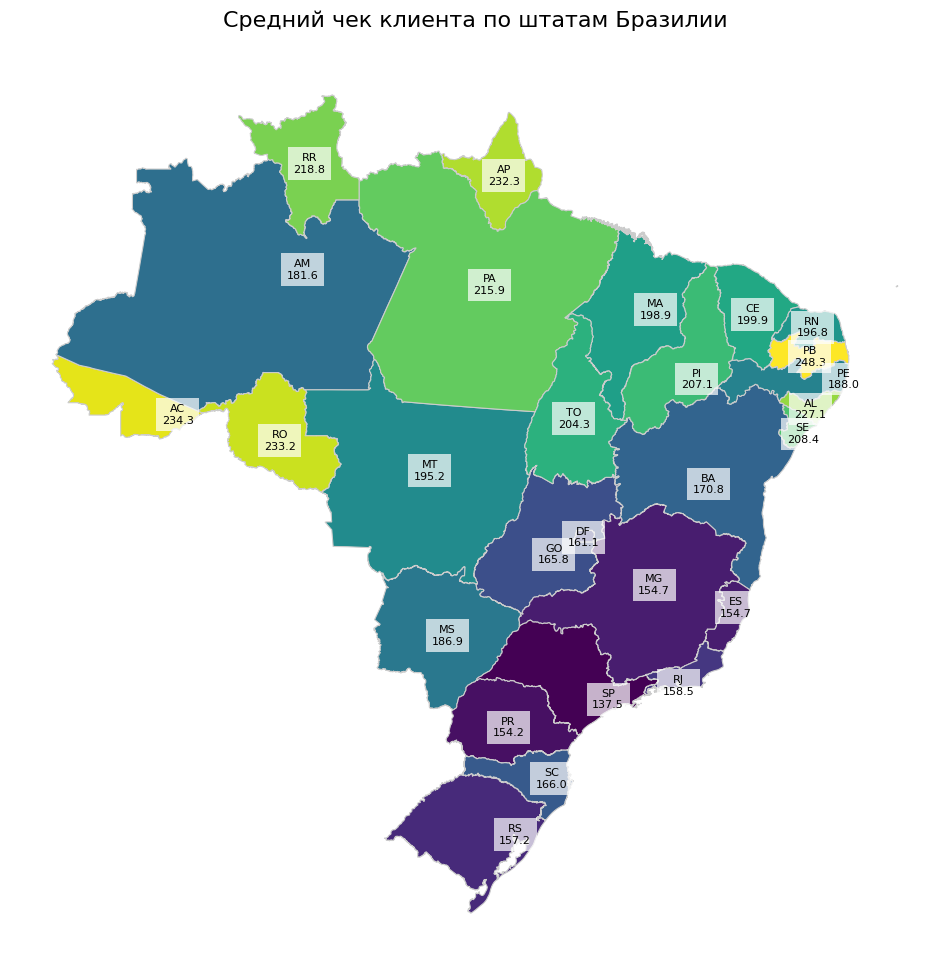

In [12]:
state_centers = {
    "PB": (-7.22, -36.72),
    "AC": (-9.97, -67.82),
    "RO": (-11.22, -62.80),
    "AP": (1.41, -51.77),
    "AL": (-9.71, -36.68),
    "RR": (1.99, -61.33),
    "PA": (-3.79, -52.48),
    "SE": (-10.90, -37.07),
    "PI": (-8.28, -42.28),
    "TO": (-10.18, -48.33),
    "CE": (-5.20, -39.53),
    "MA": (-4.96, -44.30),
    "RN": (-5.81, -36.59),
    "MT": (-12.64, -55.42),
    "PE": (-8.28, -35.07),
    "MS": (-20.51, -54.54),
    "AM": (-3.07, -61.66),
    "BA": (-13.29, -41.71),
    "SC": (-27.33, -49.44),
    "GO": (-16.64, -49.31),
    "DF": (-15.83, -47.86),
    "RJ": (-22.90, -43.17),
    "RS": (-30.01, -51.22),
    "ES": (-19.19, -40.34),
    "MG": (-18.10, -44.38),
    "PR": (-24.89, -51.55),
    "SP": (-23.55, -46.64)
}

fig, ax = plt.subplots(1, figsize=(12, 14))

merged_data.plot(
    column="avg_order_value",
    cmap="viridis",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
)

for state, coords in state_centers.items():
    avg_check = merged_data[merged_data["sigla"] == state]["avg_order_value"].values[0]
    ax.text(
        coords[1], coords[0], f"{state}\n{avg_check:.1f}", 
        fontsize=8, ha="center", va="center", color="black", 
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

plt.title("Средний чек клиента по штатам Бразилии", fontsize=16, pad=20)

ax.axis("off")

plt.show()

По карте видно, что на юге Бразилии средний чек меньше, чем по всей стране, штаты с самыми высокими средними чеками расположены на окраинах страны.

Посмотрим, как распределны стоимости заказа в штате с самым большим средним чеком.

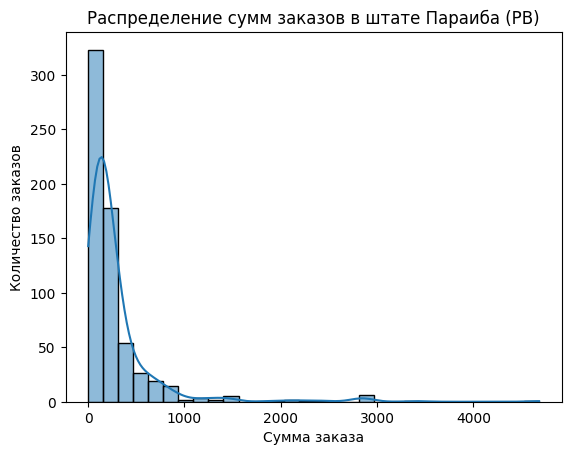

In [13]:
sns.histplot(data=task3_res[1], x="payment_value", bins=30, kde=True)
plt.title("Распределение сумм заказов в штате Параиба (PB)")
plt.xlabel("Сумма заказа")
plt.ylabel("Количество заказов")
plt.show()

Наблюдаются выбросы с большой суммой заказа порядка 3000. Откинем такие выбросы из рассмотрения и проверим рапределение на логнормальность.

In [14]:
payment_values = task3_res[1]["payment_value"].astype(float)

payment_values = payment_values[payment_values < 2000]

Нулевая гипотеза ($ H_0 $):
Данные соответствуют логнормальному распределению.

Альтернативная гипотеза ($ H_1 $):
Данные не соответствуют логнормальному распределению.

Для проверки гипотезы воспользуемся тестом Колмагорова-Смирнова.

In [15]:
shape, loc, scale = stats.lognorm.fit(payment_values, floc=0)

ks_stat, ks_pvalue = stats.kstest(payment_values, "lognorm", args=(shape, loc, scale))

print(f"KS-статистика: {ks_stat}, p-value: {ks_pvalue}")

KS-статистика: 0.04275951469602046, p-value: 0.1960846230844958


Получаем `p-value>0.05`, что говорит о том, что мы не отвергаем нулевую гипотезу о том, что данные соответствуют логнормальному распределению.

## Пункт 4

In [16]:
task4_res = execute_sql_from_file("../scripts/06_task4.sql", conn)

task4_res

[                category  cancellation_count
 0         sports_leisure                  51
 1             housewares                  49
 2  computers_accessories                  46
 3        furniture_decor                  36
 4          health_beauty                  36
 5                   toys                  34
 6                   auto                  30
 7          watches_gifts                  21
 8                   baby                  20
 9           garden_tools                  19]

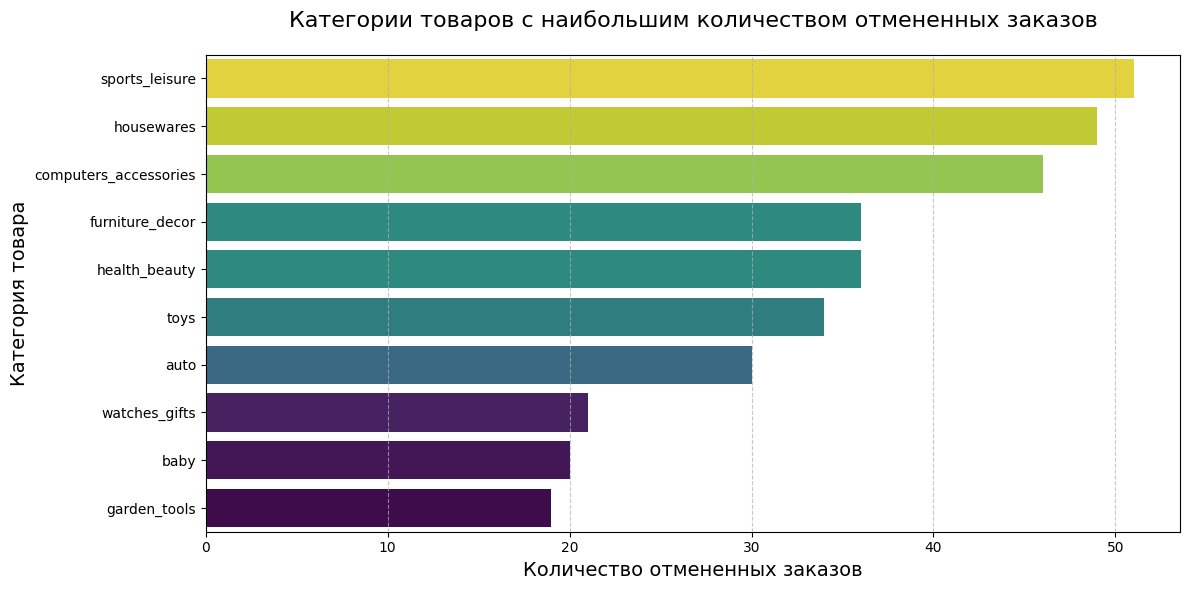

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x="cancellation_count", hue="cancellation_count", y="category", legend=False, data=task4_res[0], palette="viridis")
plt.title("Категории товаров с наибольшим количеством отмененных заказов", fontsize=16, pad=20)
plt.xlabel("Количество отмененных заказов", fontsize=14)
plt.ylabel("Категория товара", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Чаще всего попадают в отмененные заказы: спортивная экипировка, предметы домашнего обихода, компьютерные аксессуары. Скорее всего, люди отменяют товары категории "спортиная экипировка" по причине неподходящего размера, неудобства или брака. Последние две категории скорее всего чаще остальных подвергаются браку и поломках, в том числе связанным с неправильной логистикой (зеркало могло разбиться по дороге).

Закроем подключение к БД

In [18]:
conn.close()

## Выводы

В ходе работы были проанализированы категории товаров, на которые чаще всего пишут отзывы, скорость заполнения пользователями формы о качестве товара, средний чек клиентов по штатам Бразилии, а также категории товаров, которые чаще всего попадают в отмененные заказы.

**1. Категории товаров с наибольшим количеством отзывов:**
Оказалось, что чаще всего пользователи оставляют отзывы на такие категории товаров, как *красота и здоровье*, *спортивная экипировка* и *постельное белье/текстиль*. Эти категории значительно опережают другие по количеству отзывов. Это может быть связано с тем, что такие товары сложно оценить только по картинке или описанию — их качество становится очевидным только после использования. Пользователям важно проверить функциональность, удобство и долговечность таких товаров непосредственно в быту.

**2. Скорость заполнения формы о качестве товара:**
Анализ показал, что пользователи чаще всего заполняют форму в течение первых 200 часов после ее создания. После этого срока количество отзывов резко снижается. Это может объясняться тем, что пользователи либо забывают о форме, либо товар их полностью устраивает, и они не видят необходимости оставлять отзыв. Интересным примером является отзыв с самым длительным временем заполнения (порядка 518 дней). Этот отзыв имеет низкую оценку (1 балл), что может свидетельствовать о том, что пользователь вспомнил о форме только из-за возникших проблем с товаром (например, его выхода из строя).

**3. Средний чек клиентов по штатам Бразилии:**
Сравнение средних чеков по штатам выявило следующие закономерности:
- На юге Бразилии средний чек ниже, чем в остальных частях страны.
- Самые высокие средние чеки наблюдаются в штатах, расположенных на границах страны.
- Максимальный средний чек зафиксирован в штате *Параиба (PB)*, расположенном на востоке страны (самый восточный штат), и составляет **248,3**.
- Минимальный средний чек наблюдается в штате *Сан-Паулу (SP)* и составляет **137,5**.

Эти различия могут быть связаны с региональными особенностями покупательской способности, культурными предпочтениями или уровнем экономического развития каждого штата.

**4. Категории товаров, которые чаще всего попадают в отмененные заказы:**
К категориям товаров, которые чаще всего попадают в отмененные заказы, относятся *спортивная экипировка*, *предметы домашнего обихода* и *компьютерные аксессуары*. Возможные причины:
- **Спортивная экипировка:** Часто отменяется из-за несоответствия размера, неудобства или наличия брака.
- **Предметы домашнего обихода:** Отмены могут быть связаны с повреждениями при транспортировке (например, разбитые зеркала) или несоответствием ожиданиям.
- **Компьютерные аксессуары:** Электроника может часто оказываться неисправной или не соответствовать заявленным характеристикам.

Вероятно последние две категории чаще других подвержены браку и поломкам, связанным в том числе и с логичтикой.